In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import statistics as st

In [370]:
model_path = "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/v12_21_2023_16:54:04_VOOR_ml_output_VOOR.parquet"

In [371]:
station = "VOOR"

In [372]:
df = pd.read_parquet(model_path)
df = df.sort_index()

In [373]:
full_df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/12_21_2023_16:59:08_full_VOOR.parquet"
)

In [374]:
full_df["Abs_err"] = df["diff"]

In [375]:
for k in full_df.columns:
    if re.search(
        f"{station}|valid|Model forecast|Abs_err",
        k,
    ):
        continue
    else:
        full_df = full_df.drop(columns=[k])

In [376]:
df

,target_error_lead_0,Model forecast,diff
0,-0.135570,-3.913963,3.778393
1,-0.129617,-4.032679,3.903062
2,-0.132693,-4.095132,3.962439
3,-0.124617,-3.663634,3.539017
4,-0.107547,-2.614908,2.507361
...,...,...,...
31087,-0.048112,3.327865,-3.375977
31088,-0.053138,2.574702,-2.627840
31089,-0.057231,2.248422,-2.305654
31090,-0.059433,1.716581,-1.776014


In [377]:
for k in full_df.keys():
    print(k)

valid_time
valid_time_cos
valid_time_sin
t2m_VOOR
sh2_VOOR
d2m_VOOR
r2_VOOR
u10_VOOR
v10_VOOR
tp_VOOR
mslma_VOOR
orog_VOOR
tcc_VOOR
asnow_VOOR
cape_VOOR
dswrf_VOOR
dlwrf_VOOR
gh_VOOR
u_total_VOOR
u_dir_VOOR
new_tp_VOOR
lat_VOOR
lon_VOOR
elev_VOOR
tair_VOOR
ta9m_VOOR
td_VOOR
relh_VOOR
srad_VOOR
pres_VOOR
mslp_VOOR
wspd_sonic_VOOR
wmax_sonic_VOOR
wdir_sonic_VOOR
precip_total_VOOR
snow_depth_VOOR
Abs_err


In [378]:
def myround(x, base):
    return base * round(x / base)

In [379]:
# function to get unique values
def unique(list1):
    # initialize a null list
    unique_list = []

    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [380]:
def err_bucket(query, full_df, met_col, rounded_base):
    errors = []
    q_rounded = myround(query, rounded_base)

    for i, _ in enumerate(full_df[met_col]):
        rounded = myround(full_df[met_col].iloc[i], rounded_base)
        q_rounded = myround(query, rounded_base)

        if rounded == q_rounded:
            errors.append(full_df["Abs_err"].iloc[i])
    return errors

In [381]:
vars_list = [
    "tair",
    "td",
    "srad",
    "pres",
    "wmax_sonic",
    "wdir_sonic",
    "precip_total",
    "snow_depth",
]
# vars_list = ['snow_depth']

In [382]:
l = 140
queries = full_df.iloc[l, -13:]
actual = full_df.iloc[l, -1]
actual

-5.110882666650203

In [383]:
queries

tair_VOOR              1.057475
ta9m_VOOR              1.027886
td_VOOR                0.619995
relh_VOOR             96.896446
srad_VOOR              0.004413
pres_VOOR            988.403198
mslp_VOOR            989.311951
wspd_sonic_VOOR        3.501485
wmax_sonic_VOOR        5.228021
wdir_sonic_VOOR        2.512433
precip_total_VOOR      0.729996
snow_depth_VOOR       -0.003382
Abs_err               -5.110883
Name: 140, dtype: object

In [384]:
queries_ls = [
    queries[0],
    queries[2],
    queries[4],
    queries[5],
    queries[8],
    queries[9],
    queries[10],
    queries[11],
]

In [385]:
queries_ls

[1.057475,
 0.6199951,
 0.004413084,
 988.4032,
 5.228021,
 2.512433,
 0.7299957275390625,
 -0.0033822288]

In [386]:
final_df = pd.DataFrame()
i = 0
for v in vars_list:
    print(v)
    if v == "tair":
        r = 5
    if v == "td":
        r = 5
    if v == "srad":
        r = 100
    if v == "pres":
        r = 100
    if v == "wmax_sonic":
        r = 2
    if v == "wdir_sonic":
        r = 2
    if v == "precip_total":
        if queries_ls[i] == 0.0:
            exit
        else:
            r = 1
    if v == "snow_depth":
        if queries_ls[i] == 0.0:
            exit
        else:
            r = 1
    _df = pd.DataFrame()
    errors_ls = err_bucket(queries_ls[i], full_df, f"{v}_{station}", r)
    i += 1
    _df[f"errors"] = errors_ls
    final_df = pd.concat([_df, final_df])

tair
td
srad
pres
wmax_sonic
wdir_sonic
precip_total
snow_depth


In [387]:
final_df

,errors
0,3.778393
1,3.903062
2,3.962439
3,3.539017
4,2.507361
...,...
4720,-1.947924
4721,-0.995279
4722,-0.997330
4723,-1.473261


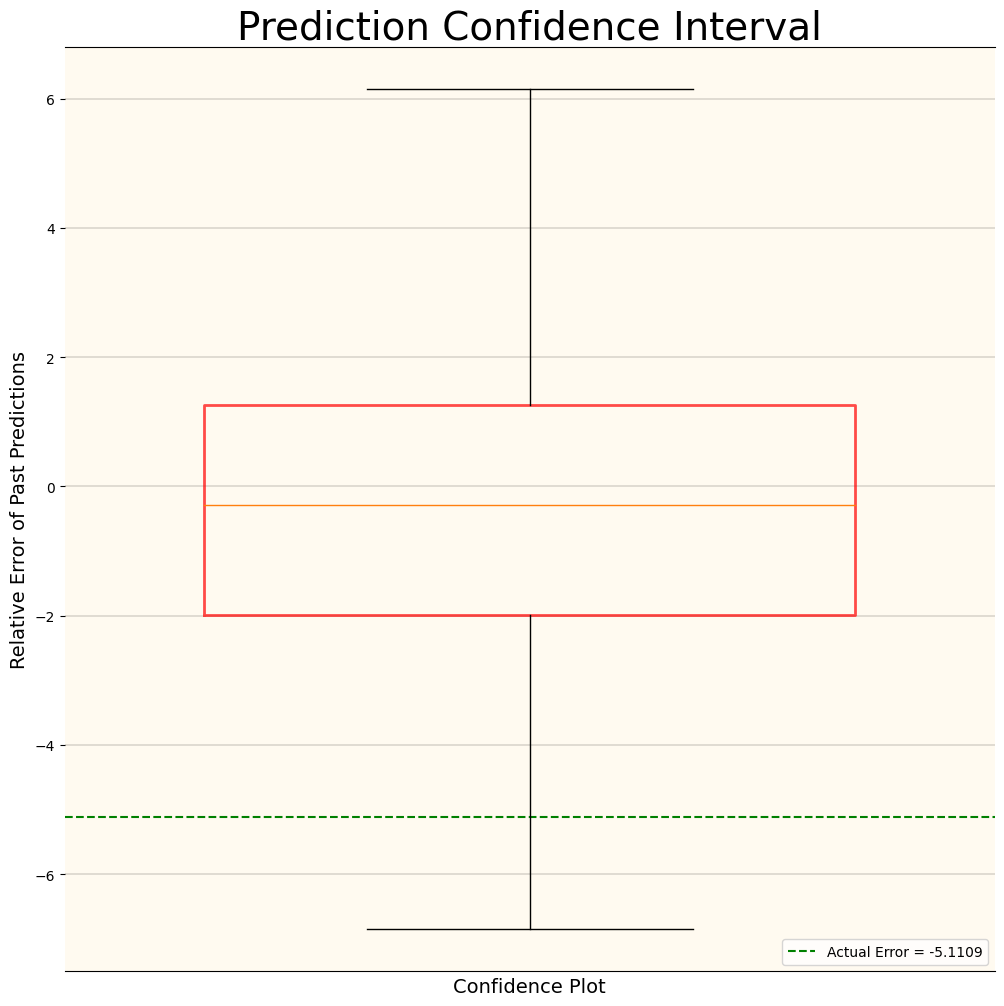

In [388]:
# Create a red boxplot
fig, ax = plt.subplots(figsize=(12, 12))

# Remove top and right border
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

# plt.ylim(-5.0,5.0)

# Add major gridlines in the y-axis
ax.grid(color="black", axis="y", linestyle="-", linewidth=0.25, alpha=0.7)
plt.axhline(
    y=actual, color="green", linestyle="--", label=f"Actual Error = {actual.round(4)}"
)

# Create a red boxplot
boxplot = ax.boxplot(
    final_df, widths=0.70, boxprops=dict(color="red"), showfliers=False, zorder=10
)

# Optionally, you can set other properties like linewidth and alpha for the boxes
for box in boxplot["boxes"]:
    box.set_linewidth(2)
    box.set_alpha(0.7)

# Set title
plt.title("Prediction Confidence Interval", fontsize=28)
# Set x-label
# Hide x-axis ticks
ax.set_xticks([])
ax.set_ylabel("Relative Error of Past Predictions", fontsize=14)
ax.set_xlabel("Confidence Plot", fontsize=14)
ax.set_facecolor("floralwhite")
ax.legend(loc="lower right")
plt.show()